# Exploratory Data Analysis - Assignment 10

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233', '#808080'])

In [3]:
df = pd.read_excel('data/impurity_dataset-training.xlsx')

In [4]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

In [5]:
all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X_dow = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y_dow = np.array(all_data[real_rows,-3], dtype='float')
y_dow = y_dow.reshape(-1,1)

## 1. k-Means

In [6]:
def dist(pt1, pt2):
    "Euclidean distance between two points"
    #note that this can also be performed with np.linalg.norm(pt1-pt2)
    return np.sqrt(sum([(xi-yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    # Expectation: find the closest points to each cluster center
    dists = [dist(pt,ci) for ci in cluster_centers] #<- find distance to each center
    min_index = dists.index(min(dists)) #<- find the index (cluster) with the minimum dist
    return min_index

def new_centers(cluster_points, centers):
    # Maximization: maximize the proximity of centers to points in a cluster
    centers = list(centers)
    for i,ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis=0)
    return centers

**Modify the code from the topic notes into a function for k-means clustering.**  

This function should take the followings as arguemnts:  
- the dataset `X`
- the initial guesses `centers`

Convergence criterion: the maximum change in distance between cluster centers `tol` < 0.1

In [7]:
def kmeans(X, centers, tol = 0.1):
    old_centers = np.array(centers)
    tolerance = 1e6
    
    while tolerance > tol:
        clusters = []
        for i in range(len(old_centers)):
            clusters.append([])
            
        for pt in X:
            cluster_idx = expected_assignment(pt, old_centers)
            clusters[cluster_idx].append(pt)
            
        new_center = new_centers(clusters, old_centers)
        
        diff = np.array(new_center) - old_centers
        length = []
        for i in range(len(old_centers)):
            length.append(np.linalg.norm(diff[i]))
        tolerance = max(length)
        
        old_centers = new_center
        
    return new_center, clusters

**Use TSNE on `X_dow` and reduce its dimensionality to 2.**

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)

X_tsne = tsne.fit_transform(X_dow)

**Pass `X_tsne` and the initial guess `centers` to the `kmeans` function you created.**  

Plot the result of clustering by color coding the points. Locate the cluster centers using `*` markers (`marker="*"`).

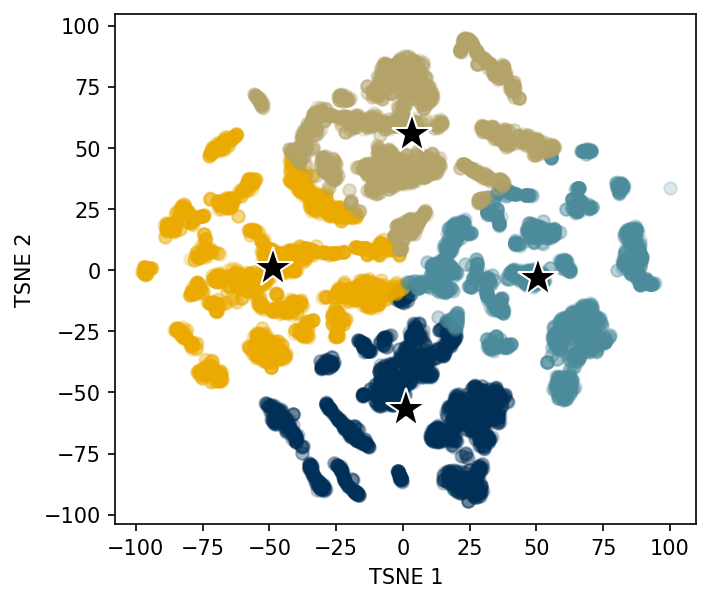

In [9]:
centers = [[5, 0], [7, 5], [100, 100], [15, 20]]

new_center, clusters = kmeans(X_tsne, centers)

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker = 'o', color = clrs[i], alpha = .2)
        
for i, ci in enumerate(new_center):
    ax.plot(ci[0], ci[1], marker = '*', markersize = 20, color = 'k', mec = 'w')
    
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2');

**Use the built-in `scikit-learn` `KMeans` model to perform k-means clustering.**

Set `n_clusters` to 4 and fit `X_tsne` to the model.  
Plot the result of clustering by color coding the points. Locate the cluster centers using `*` markers (`marker="*"`).

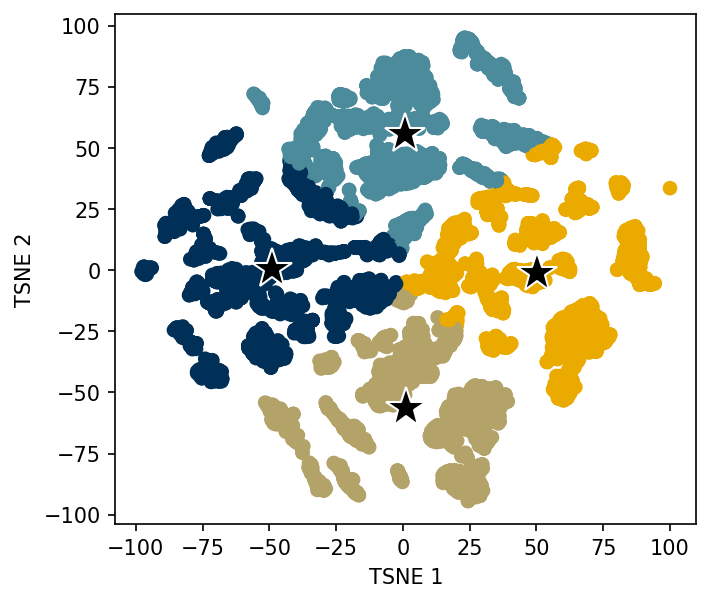

In [10]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters = 4)
y_tsne = model.fit_predict(X_tsne)
centers = model.cluster_centers_

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c = clrs[y_tsne])

for center in centers:
    x_i = center[0]
    y_i = center[1]
    ax.plot(x_i, y_i, marker = '*', color = 'k', mec = 'w', markersize = 20)
    
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2');

**Do the results of your implementation match the `scikit-learn` implementation? If not, briefly explain what might cause the discrepancy.**

> We used the different convergence criterion (`tol = 0.1`) whereas the `scikit-learn` implementaion uses `tol = 0.0001`.

> `scikit-learn` k-means model utilizes the different EM algorithm called the **Elkan** algorithm.

## 2. Silhouette Score vs. `bandwidth` for Mean Shift

**Load the MNIST dataset.**

In [11]:
from sklearn.datasets import load_digits

digits = load_digits()

X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

**Use `KernelPCA` on the MNIST dataset.**  

Set `n_components = 2, kernel = 'rbf'` and use default values for all other hyperparameters.

In [12]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components = 2, kernel = 'rbf')
X_kpca = kpca.fit_transform(X_mnist)

**Plot the silhouette score as a function of `bandwidth` for the `MeanShift` model.**  

Apply mean shift algorithm to `X_kpca`.  Vary the `bandwidth` in the range [0.01, 0.05, 0.1, 0.2, 0.25].  

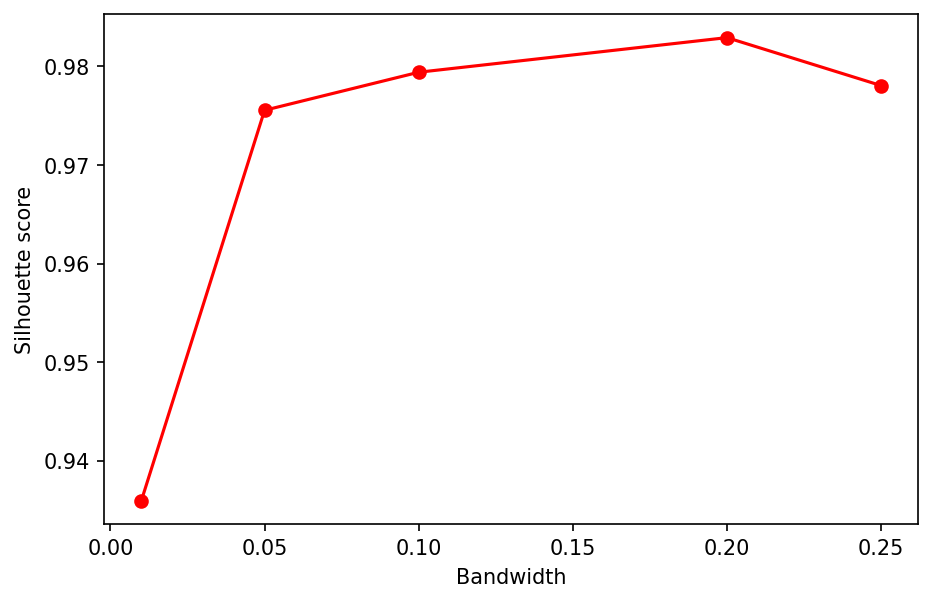

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.25]

silhouette = []
for bw in bandwidth:
    ms = MeanShift(bandwidth = bw)
    y_kpca = ms.fit_predict(X_kpca)
    
    silhouette.append(silhouette_score(X_kpca, y_kpca))
    
fig, ax = plt.subplots(figsize = (7, 4.5), dpi = 150)
ax.plot(bandwidth, silhouette, 'r-', marker = 'o')
ax.set_xlabel('Bandwidth')
ax.set_ylabel('Silhouette score');

**Plot the resulting clustering from the best model.**  

Plot the result of clustering by color coding the points. Locate the cluster centers using `*` markers (`marker="*"`).

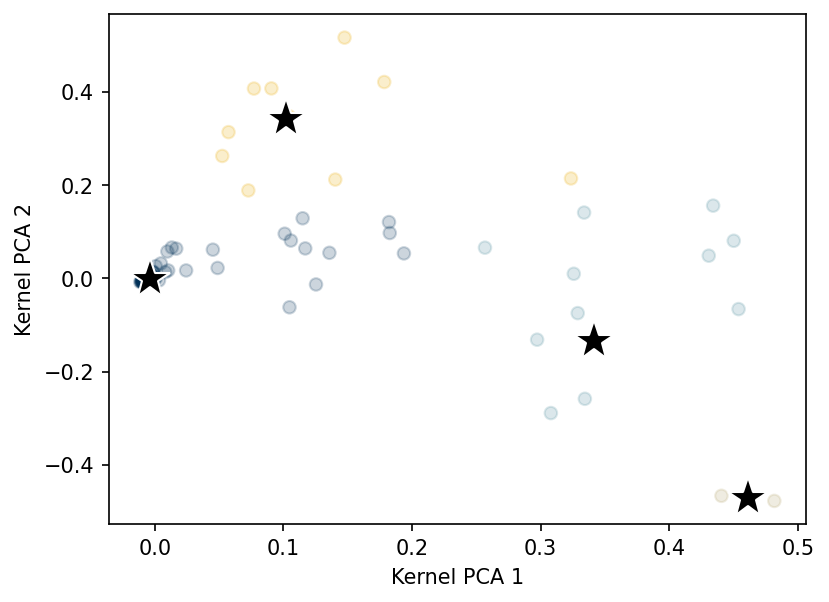

In [14]:
best_ms = MeanShift(bandwidth = 0.2)
y_kpca = best_ms.fit_predict(X_kpca)
centers = best_ms.cluster_centers_

fig, ax = plt.subplots(figsize = (6, 4.5), dpi = 150)
ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c = clrs[y_kpca], alpha = .2)

for center in centers:
    x_i = center[0]
    y_i = center[1]
    ax.plot(x_i, y_i, marker = '*', color = 'k', mec = 'w', markersize = 20)
    
ax.set_xlabel('Kernel PCA 1')
ax.set_ylabel('Kernel PCA 2');

## 3. Generative Model for Handwritten Digit

**Select the points labeled as 6 in the MNIST dataset.**

In [15]:
X_mnist_6 = X_mnist[y_mnist == 6]

**Train a kernel density estimation (KDE) model.**

Use a bandwidth of 0.35 and a Gaussian kernel. 

In [16]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth = 0.35, kernel = 'gaussian')
kde.fit(X_mnist_6);

**Visualize an example of a synthetic 6 generated by the KDE model.**

In [17]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    colormap = ax.imshow(img,cmap='binary',vmin=0,vmax=16)
    fig.colorbar(colormap, ax=ax)

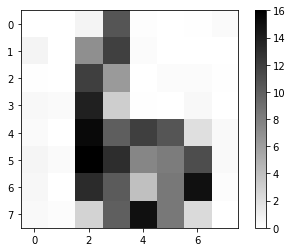

In [18]:
sample_6 = kde.sample(1)
show_image(sample_6, 0)

**6745 Only: Find the optimal number of Gaussians by using BIC.**  

You will use GMM in this problem.  
Use `covariance_type = full` and train the GMM models with `X_mnist_6`.  
You should search over `n_components` from 2 to 40.  
Plot the BIC vs. `n_components`.

Optimal number of Gaussians: 2


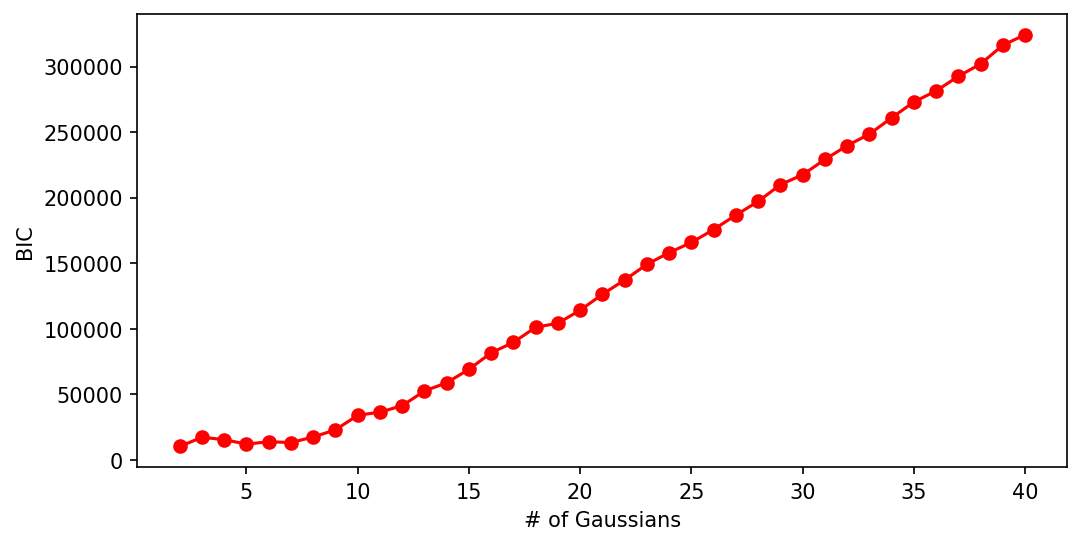

In [19]:
from sklearn.mixture import GaussianMixture
n_Gaussian = range(2, 41)

BICs = []
for n in n_Gaussian:
    gmm = GaussianMixture(n_components = n, covariance_type = 'full').fit(X_mnist_6)
    bic = gmm.bic(X_mnist_6)
    BICs.append(bic)
    
fig, ax = plt.subplots(figsize = (8, 4), dpi = 150)
ax.plot(n_Gaussian, BICs, 'r-', marker = 'o')
ax.set_xlabel('# of Gaussians')
ax.set_ylabel('BIC')

optimal_n = n_Gaussian[BICs.index(min(BICs))]
print('Optimal number of Gaussians: {}'.format(optimal_n))

**6745 Only: Which model (GMM or KDE) would you expect to perform better in a Bayesian classification scheme? Briefly explain.**

> KDE is better than GMM in a Bayesian classification scheme. In a Bayesian classification, it is important to get a very reliable class-conditional probability density functions of a finite continuous data. KDE is more flexible in terms of estimating PDFs since GMMs assume that the data follows a normal distribution.  